In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
sujaymann_handwritten_english_characters_and_digits_path = kagglehub.dataset_download('sujaymann/handwritten-english-characters-and-digits')

print('Data source import complete.')


## Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import tensorflow
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Input,Flatten,Dense,Dropout
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import string
import seaborn as sns
import os

print(np.__version__)
print(pd.__version__)
print(tensorflow.__version__)
print(keras.__version__)

2025-06-13 02:14:24.626585: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-13 02:14:24.626695: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-13 02:14:24.761518: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


1.26.4
2.2.2
2.15.0
3.4.1


## Create training and testing datasets from directories

In [ ]:
train_ds = image_dataset_from_directory(
    directory = '/kaggle/input/handwritten-english-characters-and-digits/augmented_images/augmented_images1',
    labels = 'inferred',
    label_mode = 'int',
    image_size = (224, 224),
    shuffle = True
)

test_ds1 = image_dataset_from_directory(
    directory = '/kaggle/input/handwritten-english-characters-and-digits/handwritten-english-characters-and-digits/combined_folder/train',
    labels = 'inferred',
    label_mode = 'int',
    image_size = (224, 224)
)

test_ds2 = image_dataset_from_directory(
    directory = '/kaggle/input/handwritten-english-characters-and-digits/handwritten-english-characters-and-digits/combined_folder/test',
    labels = 'inferred',
    label_mode = 'int',
    image_size = (224, 224)
)

test_ds = test_ds1.concatenate(test_ds2)

Found 13640 files belonging to 62 classes.
Found 2728 files belonging to 62 classes.
Found 682 files belonging to 62 classes.


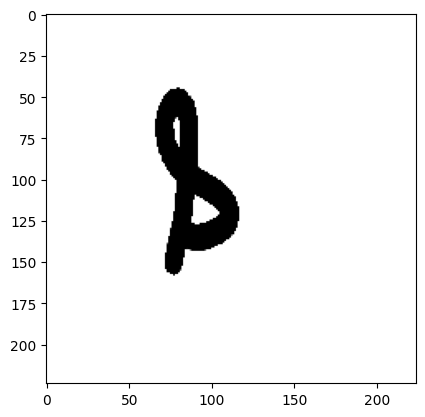

In [ ]:
image, label = next(iter(train_ds))
plt.imshow(image[0])

## Normalize Image Values

In [ ]:
train_ds_norm = train_ds.map(lambda x, y: (x / 255.0, y))
test_ds_norm = test_ds.map(lambda x, y: (x / 255.0, y))

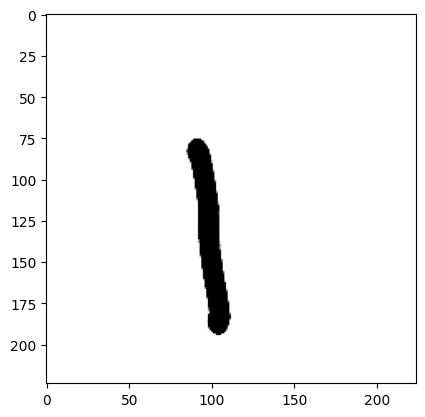

In [ ]:
image, label = next(iter(train_ds_norm))
plt.imshow(image[0])

In [ ]:
len(train_ds)

427

In [ ]:
len(test_ds)

108

## Splitting data into train and val set

In [ ]:
train_size = int(0.8 * len(train_ds_norm))
print(train_size)
val_ds_norm = train_ds_norm.skip(train_size)
train_ds_norm = train_ds_norm.take(train_size)

341


In [ ]:
len(train_ds_norm)

341

In [ ]:
len(val_ds_norm)

86

## VGG19 Model for Transfer Learning

In [ ]:
conv_base = VGG19(
    weights = 'imagenet',
    include_top = False,
    input_shape = (224, 224, 3)
)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### Freeze weights

In [ ]:
conv_base.trainable = False

In [ ]:
conv_base.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

## Add Fully Connected Layers

In [ ]:
model = Sequential()
model.add(Input(shape=(224,224,3)))
model.add(conv_base)
model.add(Flatten())
model.add(Dense(224,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(416,activation='sigmoid'))
model.add(Dropout(0.1))
model.add(Dense(62,activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 224)            │     5,619,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 224)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 416)            │        93,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 416)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 62)             │        25,854 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,763,774 (98.28 MB)

 Trainable params: 5,739,390 (21.89 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])

## Model Training

In [ ]:
history = model.fit(train_ds_norm, epochs=50, validation_data=val_ds_norm)

Epoch 1/50
  1/341 ━━━━━━━━━━━━━━━━━━━━ 3:16:57 35s/step - accuracy: 0.0312 - loss: 4.3036

I0000 00:00:1749781010.737891     120 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1749781010.752449     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


341/341 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.0194 - loss: 4.2093

W0000 00:00:1749781091.993718     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


341/341 ━━━━━━━━━━━━━━━━━━━━ 140s 310ms/step - accuracy: 0.0194 - loss: 4.2092 - val_accuracy: 0.0469 - val_loss: 4.0631
Epoch 2/50


W0000 00:00:1749781116.100392     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


341/341 ━━━━━━━━━━━━━━━━━━━━ 97s 285ms/step - accuracy: 0.0358 - loss: 4.0611 - val_accuracy: 0.1004 - val_loss: 3.8944
Epoch 3/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 98s 286ms/step - accuracy: 0.0922 - loss: 3.8586 - val_accuracy: 0.2119 - val_loss: 3.5871
Epoch 4/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 98s 288ms/step - accuracy: 0.1611 - loss: 3.5487 - val_accuracy: 0.2672 - val_loss: 3.2493
Epoch 5/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 98s 286ms/step - accuracy: 0.2271 - loss: 3.2097 - val_accuracy: 0.3567 - val_loss: 2.9036
Epoch 6/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 98s 287ms/step - accuracy: 0.2959 - loss: 2.9032 - val_accuracy: 0.4205 - val_loss: 2.6345
Epoch 7/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 98s 288ms/step - accuracy: 0.3701 - loss: 2.6260 - val_accuracy: 0.4817 - val_loss: 2.3347
Epoch 8/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 98s 287ms/step - accuracy: 0.4240 - loss: 2.3839 - val_accuracy: 0.5040 - val_loss: 2.1530
Epoch 9/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 98s 287ms/step - accuracy: 0.4657 - loss: 2.1751 - val

## Accuracy Curve

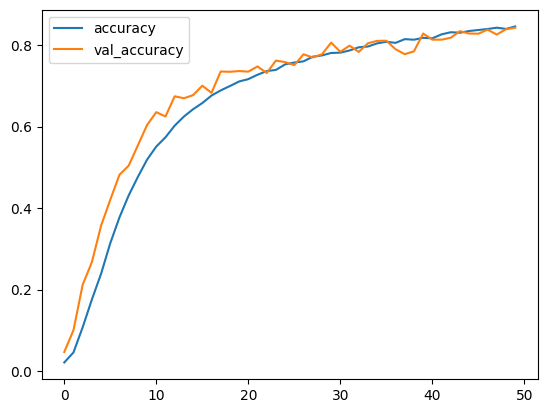

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

## Loss Curve

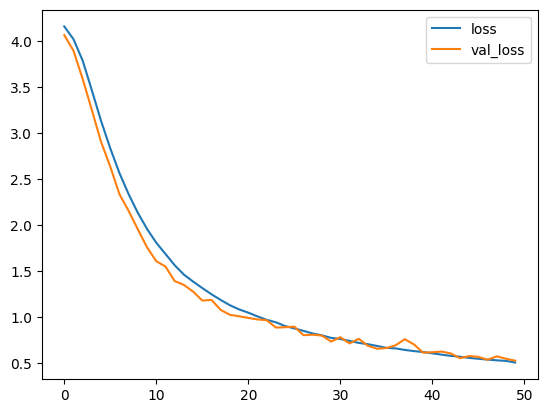

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

## Evaluation on training data

In [ ]:
loss, accuracy = model.evaluate(train_ds_norm)
print("Loss:", loss)
print("Accuracy:", accuracy)

341/341 ━━━━━━━━━━━━━━━━━━━━ 55s 160ms/step - accuracy: 0.8879 - loss: 0.4012
Loss: 0.4062530994415283
Accuracy: 0.883980929851532


## Evaluation on testing data

In [ ]:
loss, accuracy = model.evaluate(test_ds_norm)
print("Loss:", loss)
print("Accuracy:", accuracy)

108/108 ━━━━━━━━━━━━━━━━━━━━ 17s 161ms/step - accuracy: 0.8976 - loss: 0.3416
Loss: 0.3876709043979645
Accuracy: 0.8841642141342163


## Evaluation on validation data

In [ ]:
loss, accuracy = model.evaluate(val_ds_norm)
print("Loss:", loss)
print("Accuracy:", accuracy)

86/86 ━━━━━━━━━━━━━━━━━━━━ 42s 155ms/step - accuracy: 0.8508 - loss: 0.5250
Loss: 0.5298988819122314
Accuracy: 0.8420087695121765


## Plotting Predictions

In [ ]:
def plot_predictions(generator, model):
    # Retrieve a batch of images and true labels from the generator
    images, true_labels = next(iter(generator))

    # Extract class names from the generator
    digits = [str(i) for i in range(10)]
    uppercase = [i for i in string.ascii_uppercase]
    lowercase = [i for i in string.ascii_lowercase]
    class_names = digits + uppercase + lowercase

    # Convert TensorFlow tensors to NumPy arrays if necessary
    if isinstance(true_labels, tensorflow.Tensor):
        true_labels = true_labels.numpy()
    if isinstance(images, tensorflow.Tensor):
        images = images.numpy()

    # Convert true_labels to class indices if they are one-hot encoded
    if true_labels.ndim > 1 and true_labels.shape[1] > 1:
        true_labels = np.argmax(true_labels, axis=1)

    # Ensure true_labels are integers
    true_labels = true_labels.astype(int)

    # Make predictions on the batch of images
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1).astype(int)

    # Check dimensions and types
    print(f'Images shape: {images.shape}')
    print(f'True labels shape: {true_labels.shape}, dtype: {true_labels.dtype}')
    print(f'Predicted classes shape: {predicted_classes.shape}, dtype: {predicted_classes.dtype}')

    # Set up the plot
    num_images = len(images)
    print(f'Number of images: {num_images}')

    # Calculate the number of rows needed
    num_cols = 6
    num_rows = int(np.ceil(num_images / num_cols))

    # Create subplots
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 5 * num_rows))

    # Flatten axes array for easy iteration
    axes = axes.flatten()

    for i in range(num_images):
        ax = axes[i]
        img = images[i]
        true_label_index = true_labels[i]
        predicted_label_index = predicted_classes[i]

        # Rescale the image if it was scaled during preprocessing
        img = img.astype(np.uint8)

        # Plot the image
        ax.imshow(img)
        ax.axis('off')

        # Get class names
        true_label_name = class_names[true_label_index]
        predicted_label_name = class_names[predicted_label_index]

        # Display true and predicted class names as text
        ax.set_title(f'True: {true_label_name}\nPred: {predicted_label_name}')

    # Hide any unused subplots
    for j in range(num_images, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Images shape: (32, 224, 224, 3)
True labels shape: (32,), dtype: int64
Predicted classes shape: (32,), dtype: int64
Number of images: 32


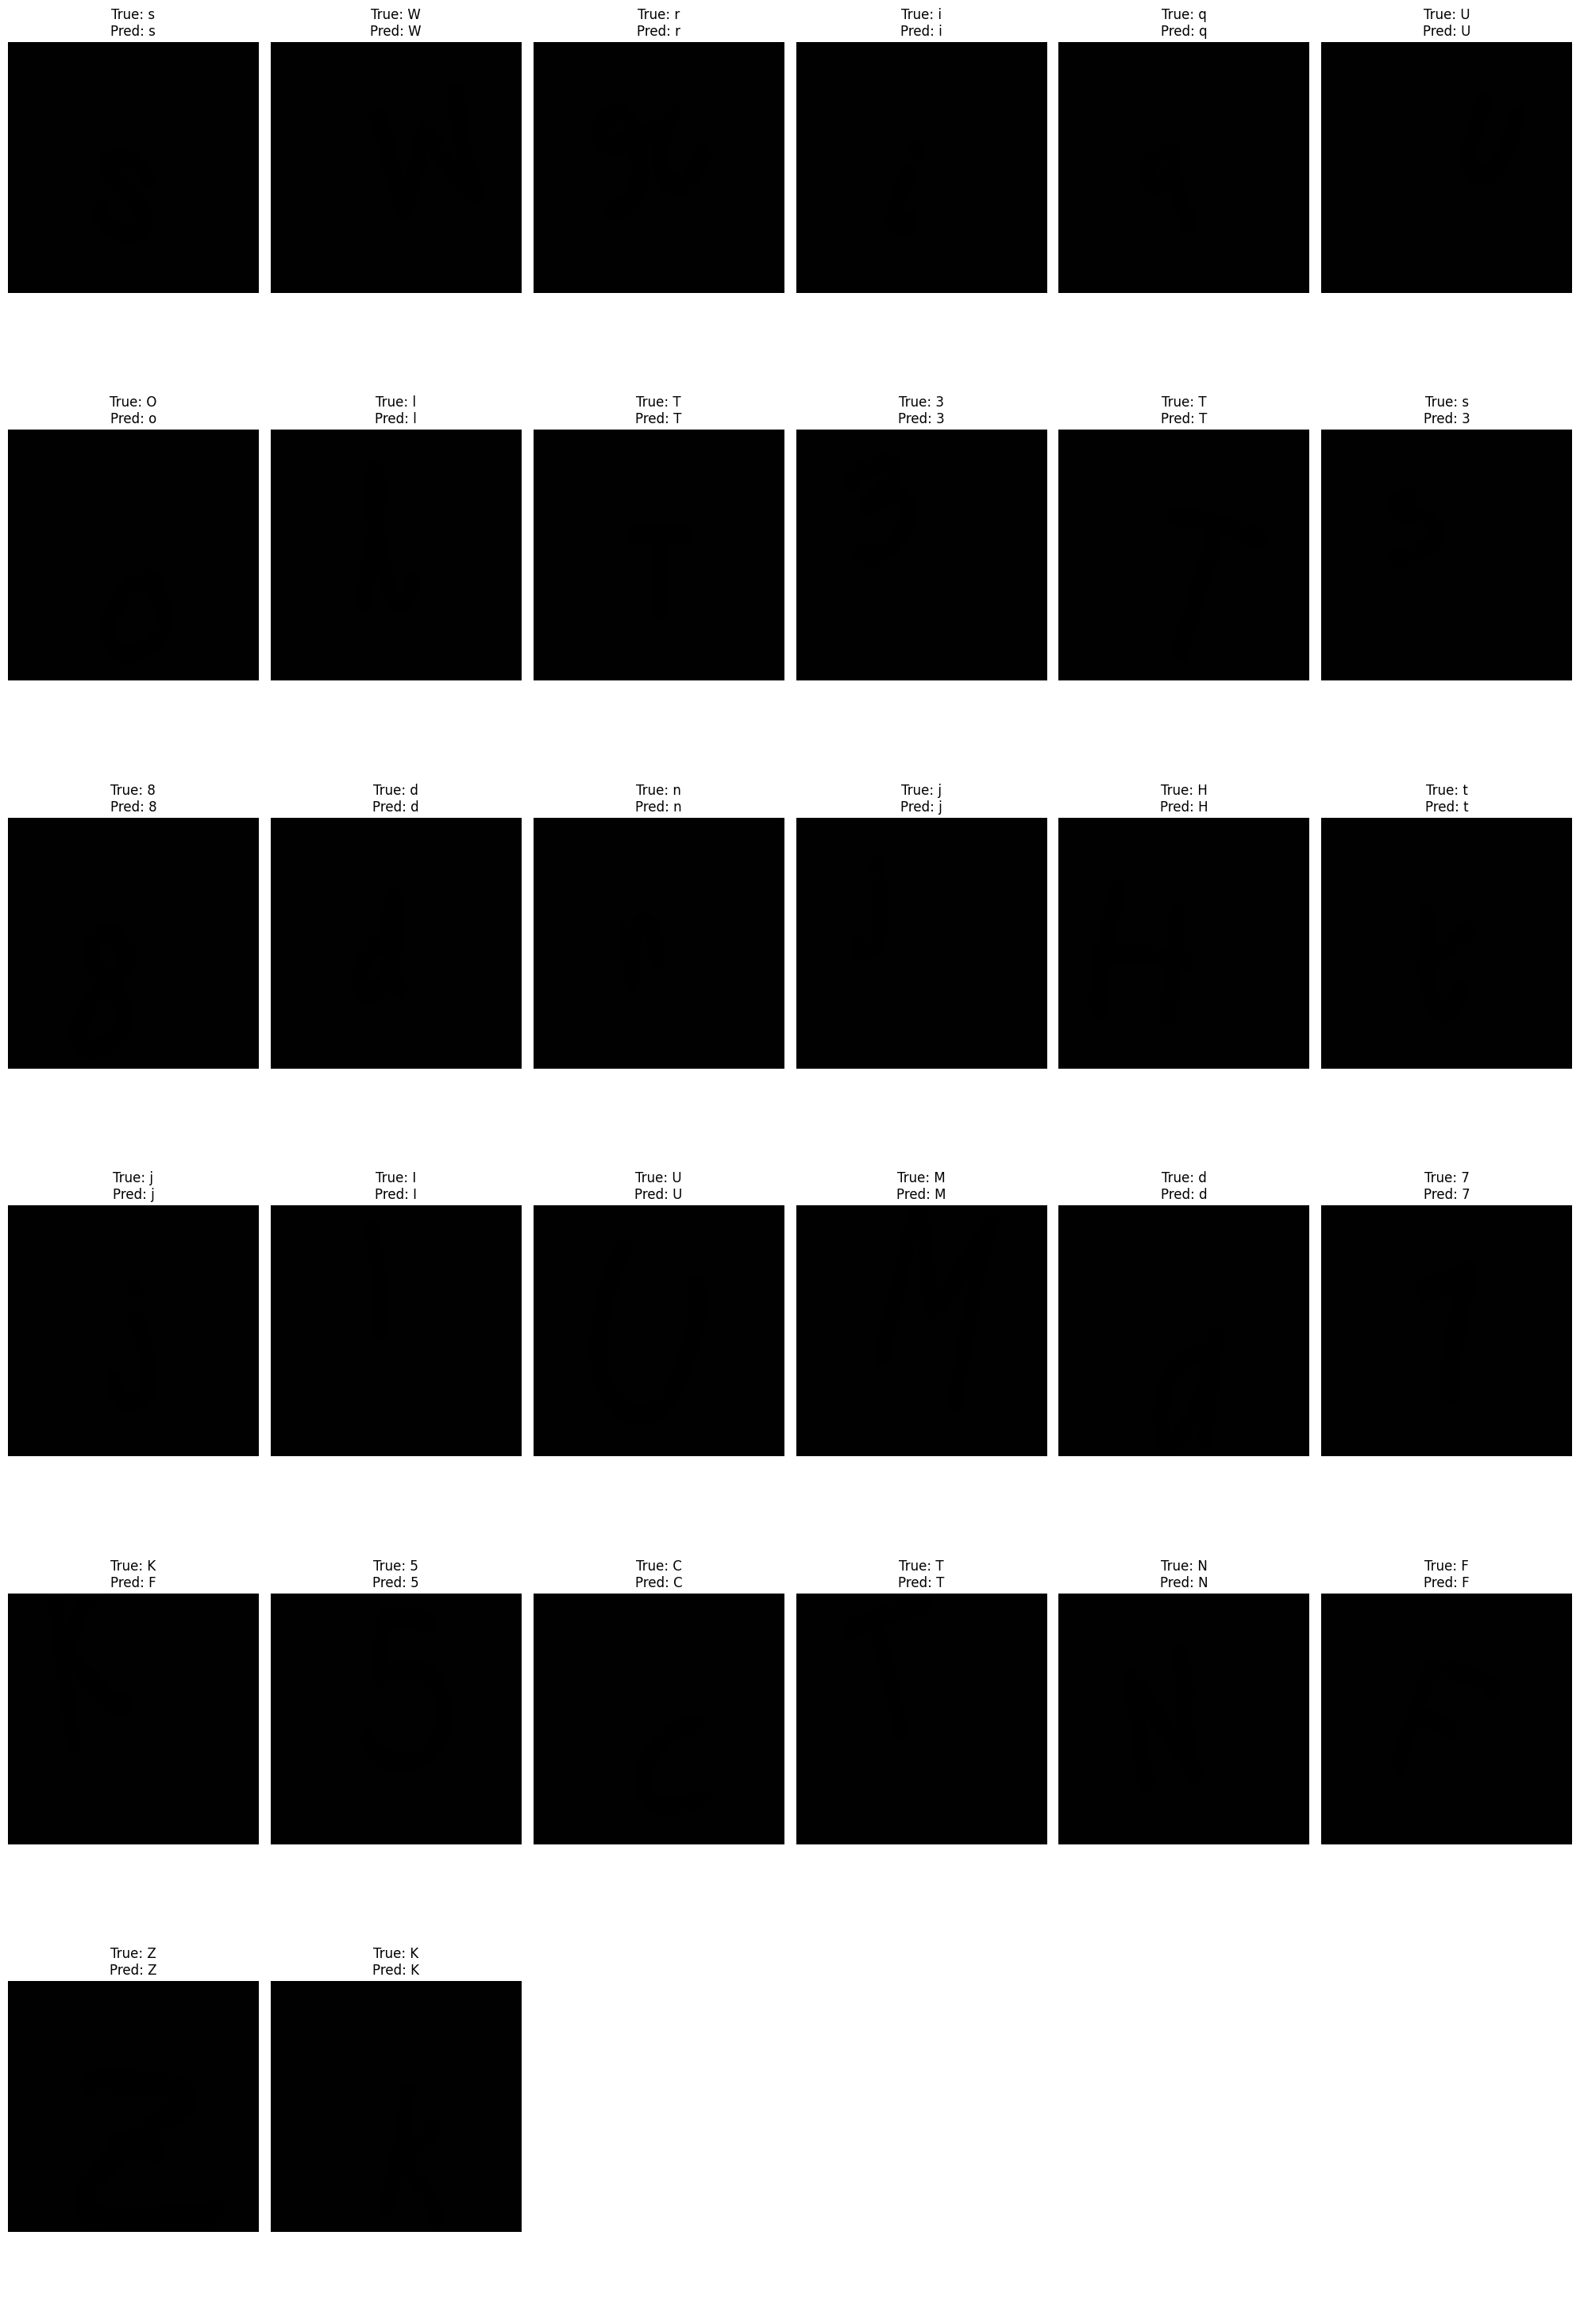

In [ ]:
plot_predictions(val_ds_norm, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Images shape: (32, 224, 224, 3)
True labels shape: (32,), dtype: int64
Predicted classes shape: (32,), dtype: int64
Number of images: 32


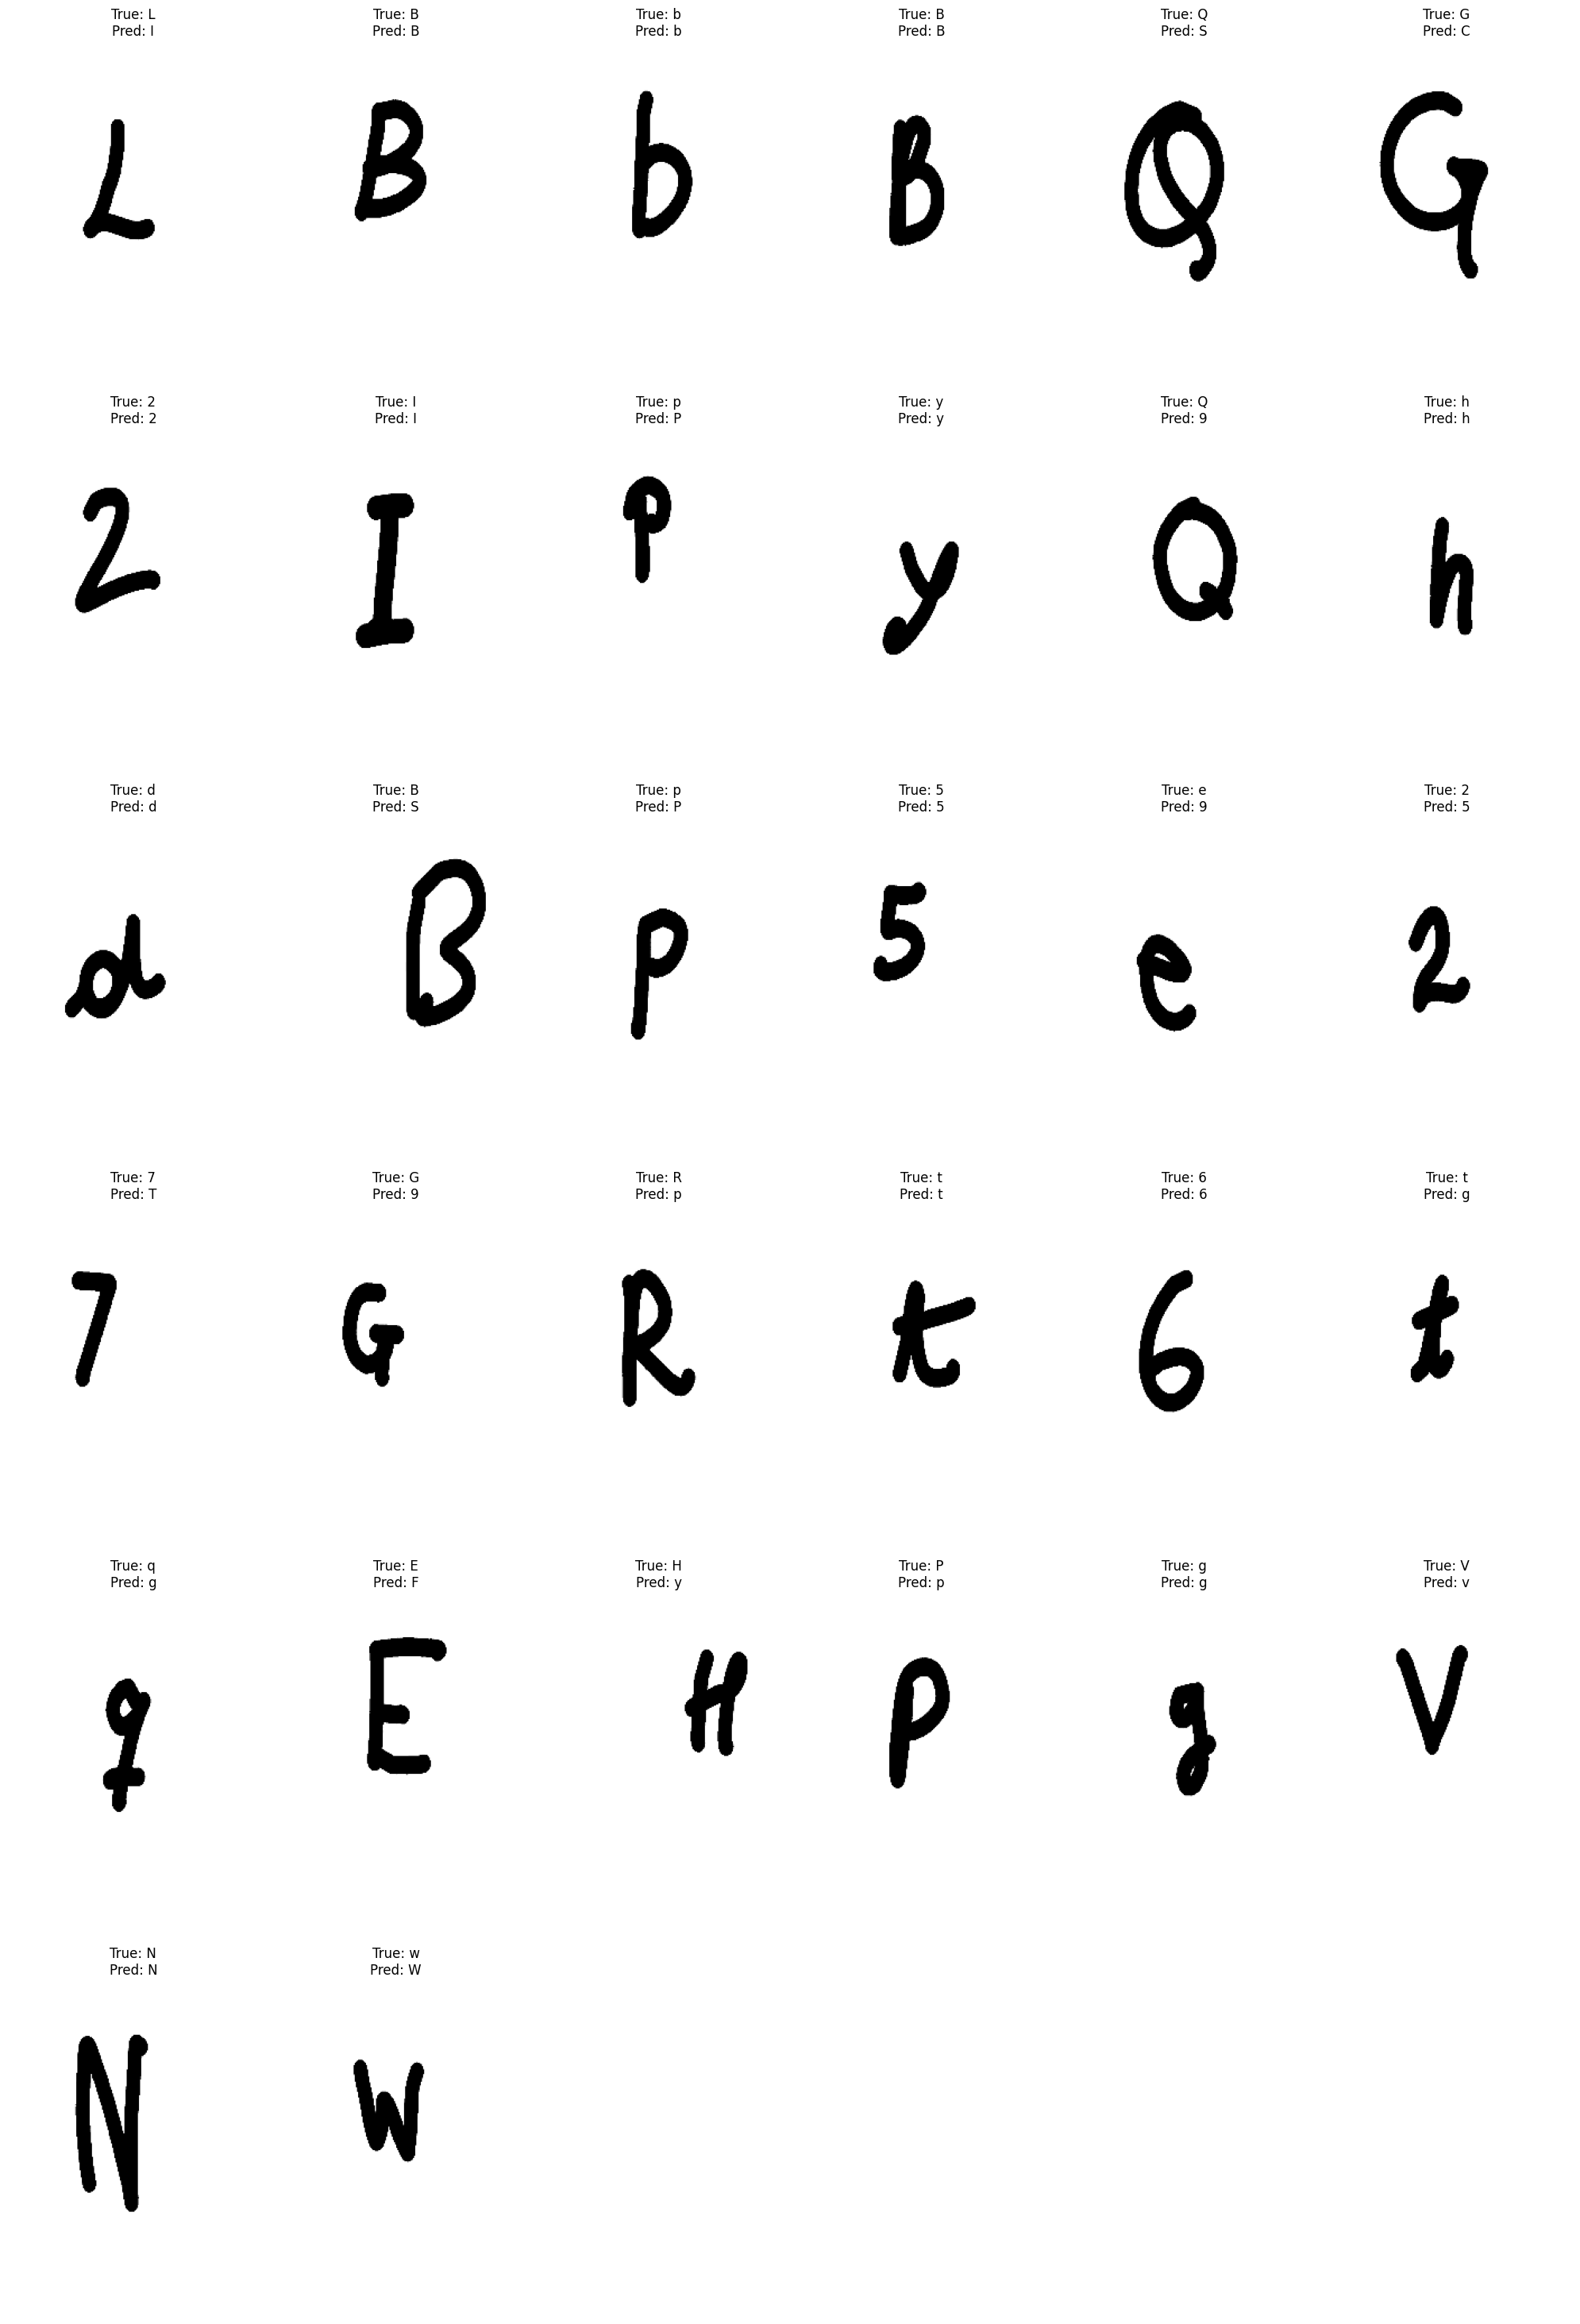

In [ ]:
plot_predictions(test_ds, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Images shape: (32, 224, 224, 3)
True labels shape: (32,), dtype: int64
Predicted classes shape: (32,), dtype: int64
Number of images: 32


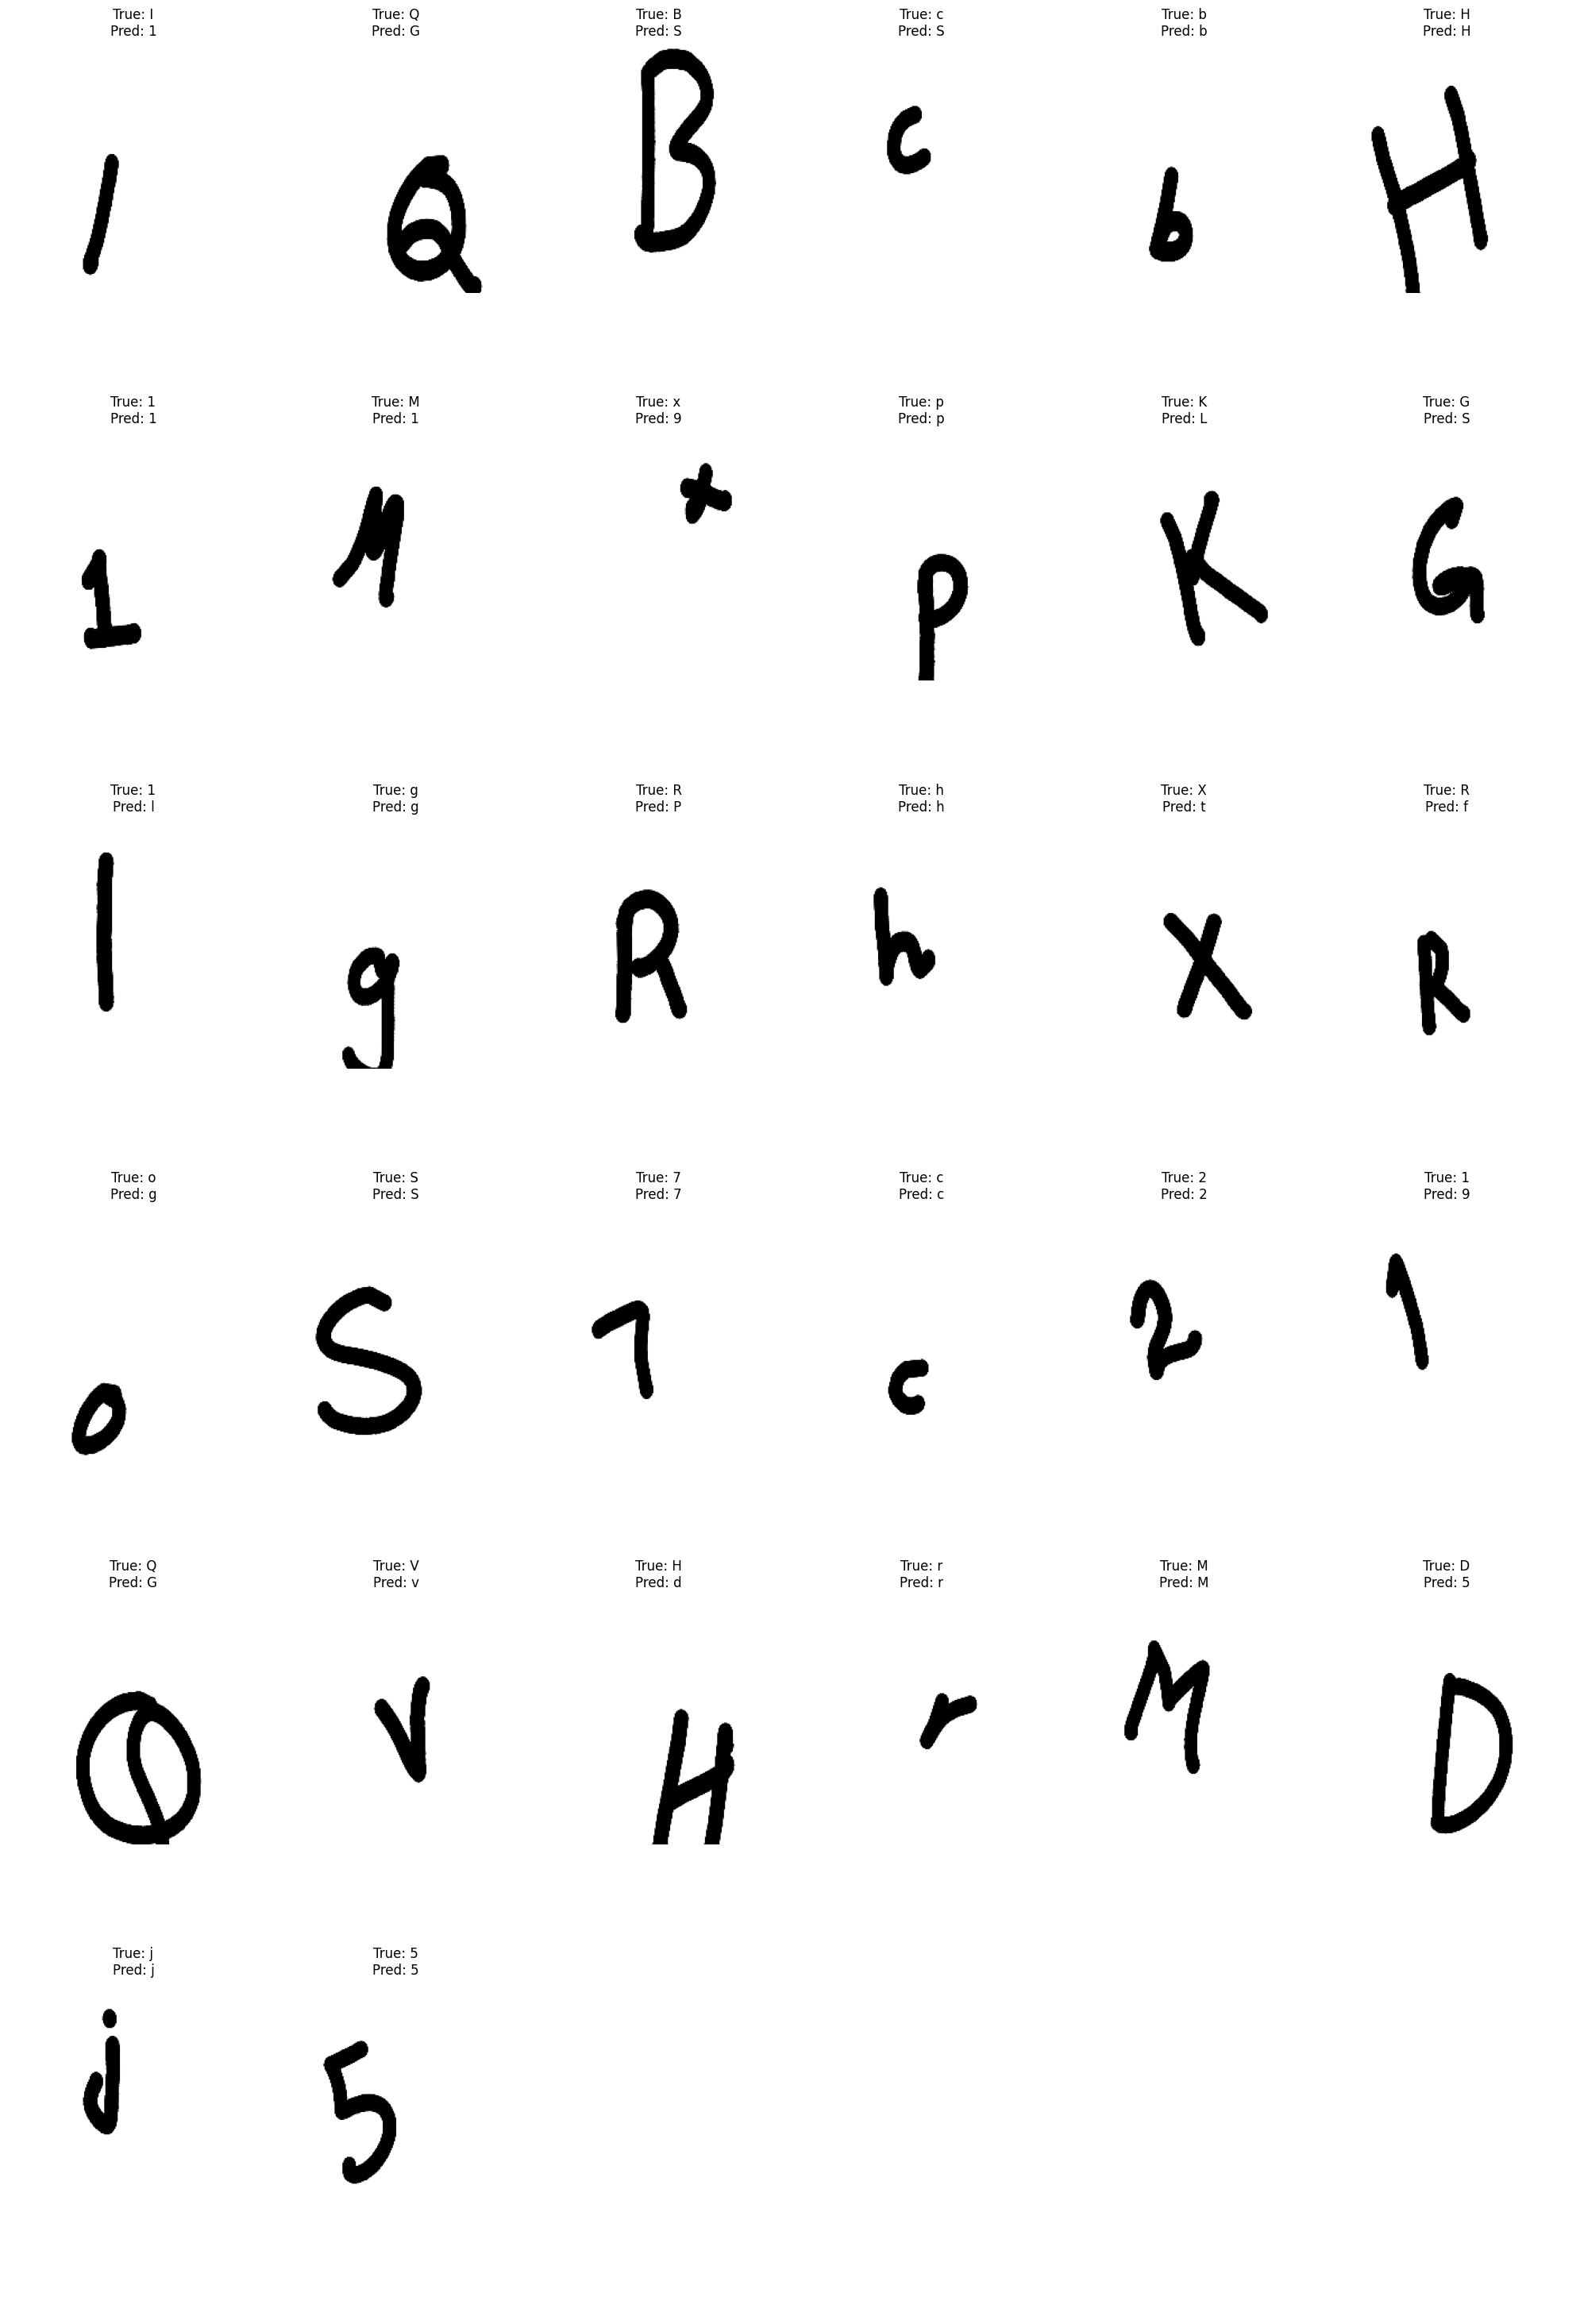

In [ ]:
plot_predictions(train_ds, model)

In [ ]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━

## Confusion Matrix

In [ ]:
cm = confusion_matrix(y_true, y_pred)

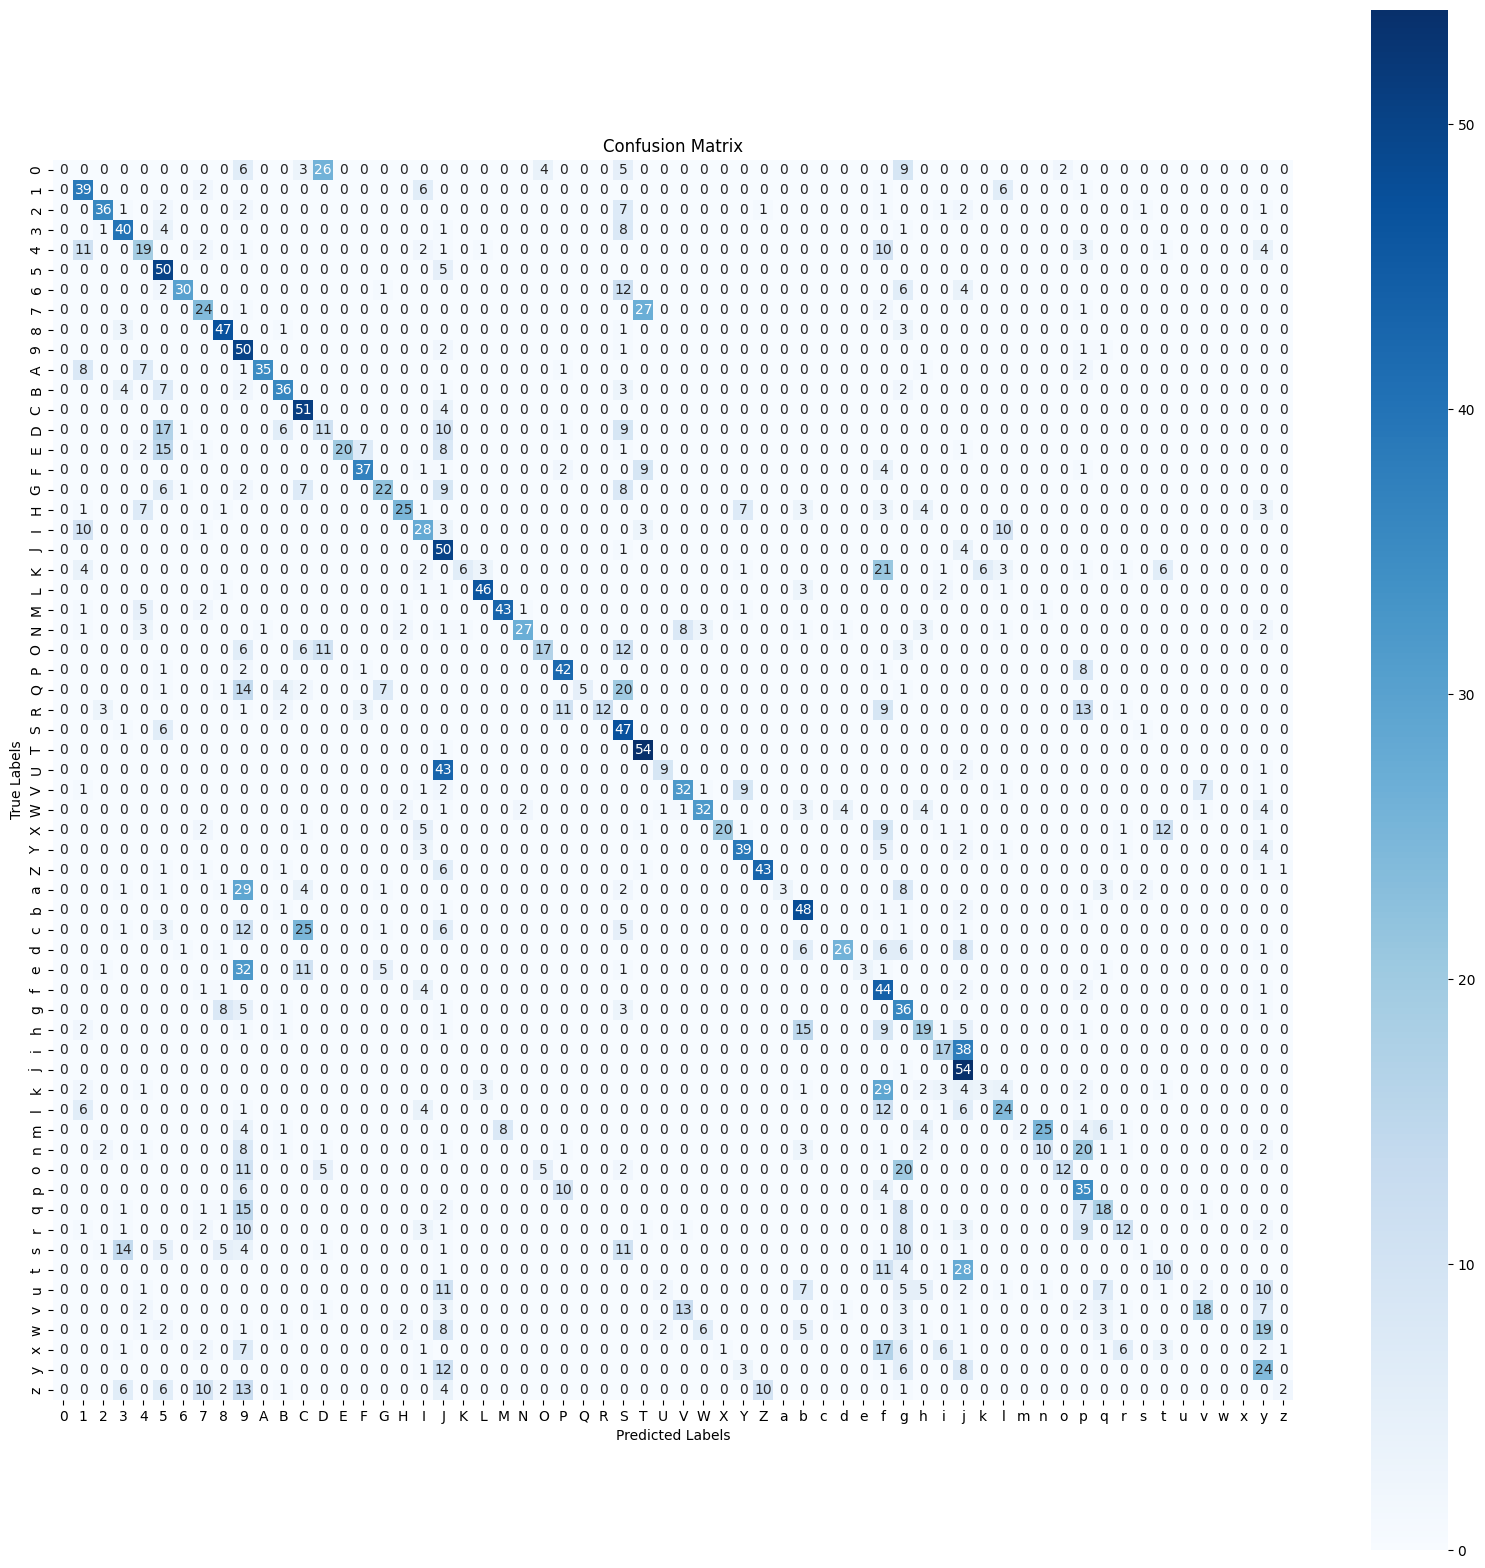

In [ ]:
digits = [str(i) for i in range(10)]
uppercase = [i for i in string.ascii_uppercase]
lowercase = [i for i in string.ascii_lowercase]
class_names = digits + uppercase + lowercase
num_classes = len(np.unique(y_true))
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

plt.figure(figsize=(20, 20))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=True, square=True,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Saving Model

In [ ]:
model.save('model.keras')